In [2]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [4]:
import zipfile

zip_path = "/content/Garbage.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/extracted_dataset")

print("Extracted!")

Extracted!


In [5]:
dataset_dir= r"/content/extracted_dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [6]:
import os
print(os.listdir(dataset_dir))
['TrashType_Image_Dataset']
dataset_dir = os.path.join(dataset_dir, 'TrashType_Image_Dataset')

['TrashType_Image_Dataset']


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=(224,224),
    batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle =False,
    image_size=(224,224),
    batch_size=32
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
# Split validation dataset into val + test
val_batches = tf.data.experimental.cardinality(val_ds)

# First half becomes test set, second half is validation
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_dat = val_dat.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6



# Visualize sample images from each class.

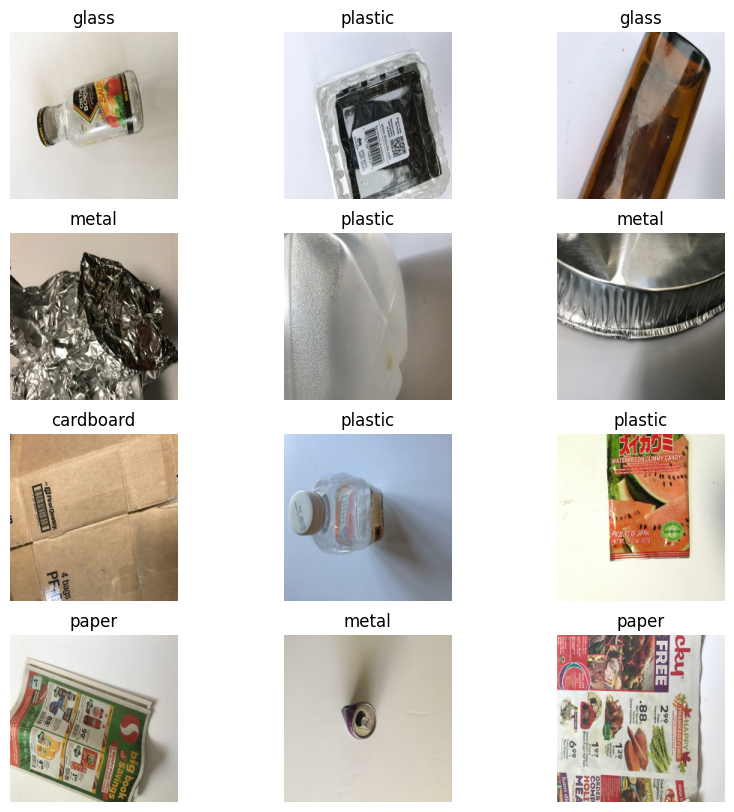

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")


.Check the number of images per class to ensure balance    
.Understand image properties like Image dimensions, Class labels

In [12]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [13]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [14]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 0.0, 'glass': 0.0, 'metal': 0.0, 'paper': 0.0, 'plastic': 72.87, 'trash': 27.13}
{'cardboard': 0.0, 'glass': 0.0, 'metal': 0.0, 'paper': 0.0, 'plastic': 100.0, 'trash': 0.0}
{'cardboard': 8.26, 'glass': 9.87, 'metal': 7.96, 'paper': 11.64, 'plastic': 46.16, 'trash': 16.11}


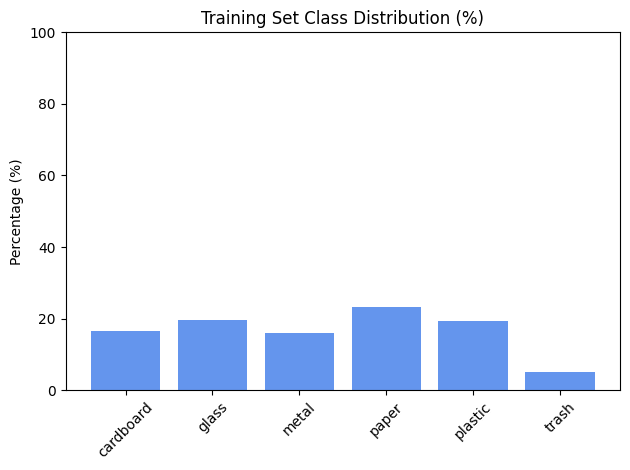

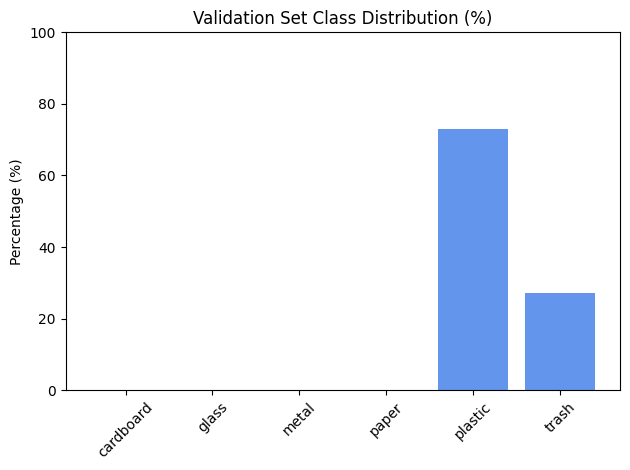

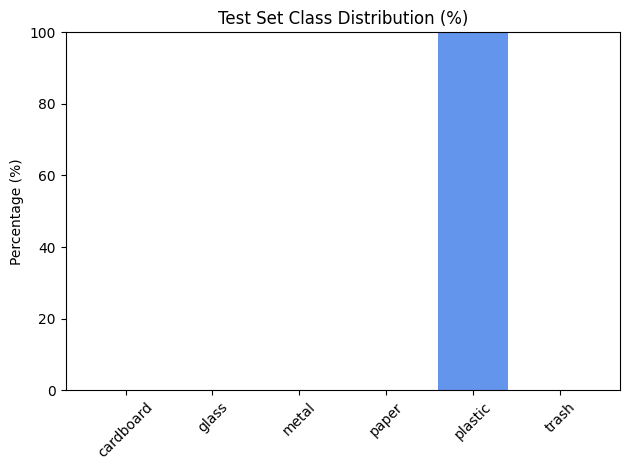

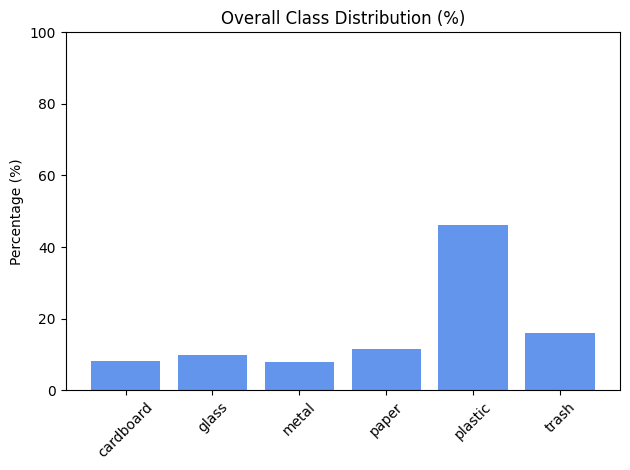

In [15]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


# Inference on Class Imbalance

In [16]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [17]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Starting Training with EfficientNetV2B0...



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3203 - loss: 1.6590
Epoch 1: val_accuracy improved from -inf to 0.73861, saving model to best_model_v2b0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 369s 5s/step - accuracy: 0.3223 - loss: 1.6561 - val_accuracy: 0.7386 - val_loss: 0.9782
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7256 - loss: 0.9314
Epoch 2: val_accuracy improved from 0.73861 to 0.86535, saving model to best_model_v2b0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.7259 - loss: 0.9301 - val_accuracy: 0.8653 - val_loss: 0.5177
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8149 - loss: 0.5841
Epoch 3: val_accuracy improved from 0.86535 to 0.90099, saving model to best_model_v2b0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.8150 - loss: 0.5835 - val_accuracy: 0.9010 - val_loss: 0.3597
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8779 - loss: 0.3797
Epoch 4: val_accuracy improved from 0.900

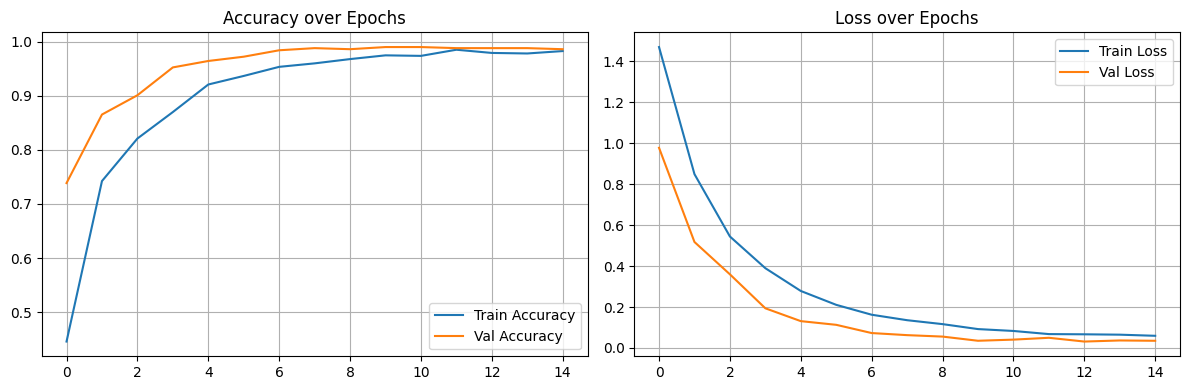

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, callbacks, optimizers
from tqdm.keras import TqdmCallback
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# 🔁 Data Augmentation Layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# ⚙️ Load Pretrained EfficientNetV2B0
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_preprocessing=True
)

# Freeze first 100 layers for transfer learning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# 🧠 Final Model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(6, activation='softmax')  # 6 output classes
])

# 🛠 Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🔔 Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model_v2b0.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 📢 Start Training
print("\n🚀 Starting Training with EfficientNetV2B0...\n")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,  # use class weights if defined
    callbacks=[early_stop, checkpoint, TqdmCallback(verbose=1)]
)

# 📊 Log Summary
df_log = pd.DataFrame(history.history)
print("\n📋 Training Log:\n", df_log.to_string(index=True))

# 💾 Save training history
with open("history_v2b0.pkl", "wb") as f:
    pickle.dump(history.history, f)

# 📈 Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,253,668 (62.00 MB)

 Trainable params: 5,163,334 (19.70 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,326,670 (39.39 MB)

In [20]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

# Model Performance Visualization: Accuracy & Loss Trends


# Model Evaluation
. Plot training and validation accuracy/loss curves.    
. Evaluate model performance on validation or test set.    
. Use metrics like:   
. Confusion Matrix    
. Classification Report (Precision, Recall, F1-score)   
. confusion_matrix, classification_report: To evaluate the model's classification performance.

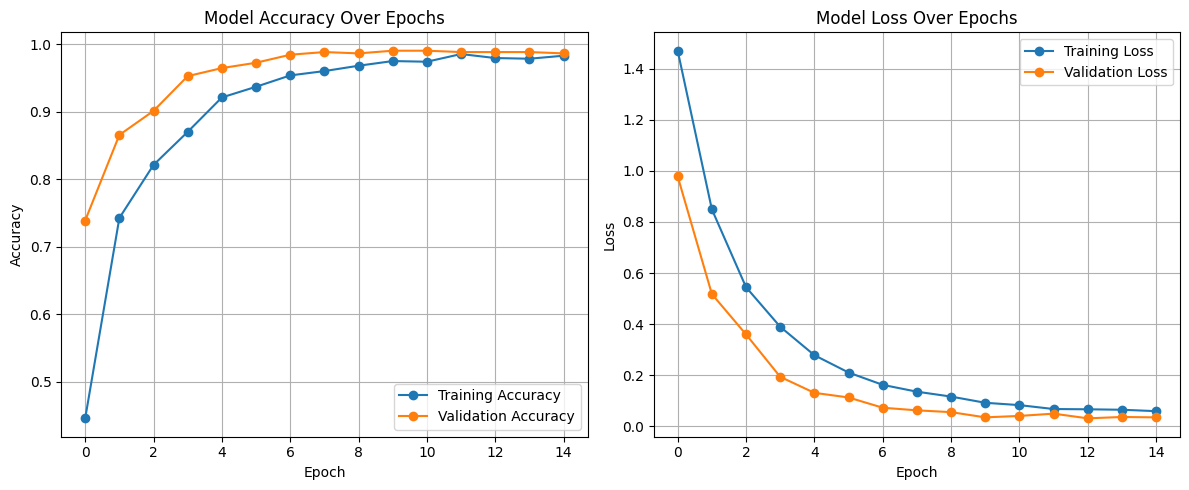

In [21]:
import matplotlib.pyplot as plt

# 📈 Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# 🔷 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 🔶 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")
# Get final train & val accuracy/loss from history
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"✅ Train Accuracy: {train_acc:.4f} | Train Loss: {train_loss:.4f}")
print(f"✅ Val Accuracy:   {val_acc:.4f} | Val Loss:   {val_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 0.0119

✅ Test Accuracy: 1.0000
📉 Test Loss: 0.0117
✅ Train Accuracy: 0.9827 | Train Loss: 0.0593
✅ Val Accuracy:   0.9861 | Val Loss:   0.0349


In [23]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
[[256]]
              precision    recall  f1-score   support

           4       1.00      1.00      1.00       256

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


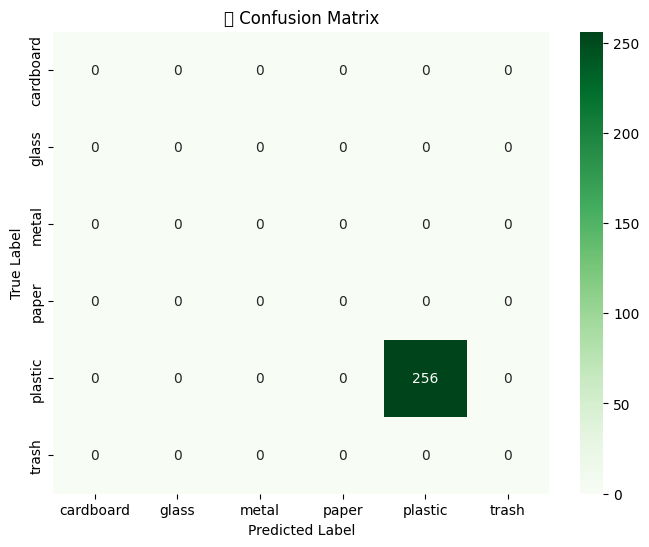

📋 Classification Report:

              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00         0
       glass       0.00      0.00      0.00         0
       metal       0.00      0.00      0.00         0
       paper       0.00      0.00      0.00         0
     plastic       1.00      1.00      1.00       256
       trash       0.00      0.00      0.00         0

    accuracy                           1.00       256
   macro avg       0.17      0.17      0.17       256
weighted avg       1.00      1.00      1.00       256



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Predict and get labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Define all possible labels
all_labels = list(range(len(train_ds.class_names)))

# 📌 Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=all_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens',
            xticklabels=train_ds.class_names,
            yticklabels=train_ds.class_names)
plt.title("🧾 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 📌 Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_ds.class_names, labels=all_labels, zero_division=0))

# Final Testing and Save the Model
Evaluate the final model on the unseen test dataset.

In [25]:
# 📊 Final test evaluation
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")
print(f"📉 Final Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 1.0000 - loss: 0.0119

✅ Final Test Accuracy: 1.0000
📉 Final Test Loss: 0.0117


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


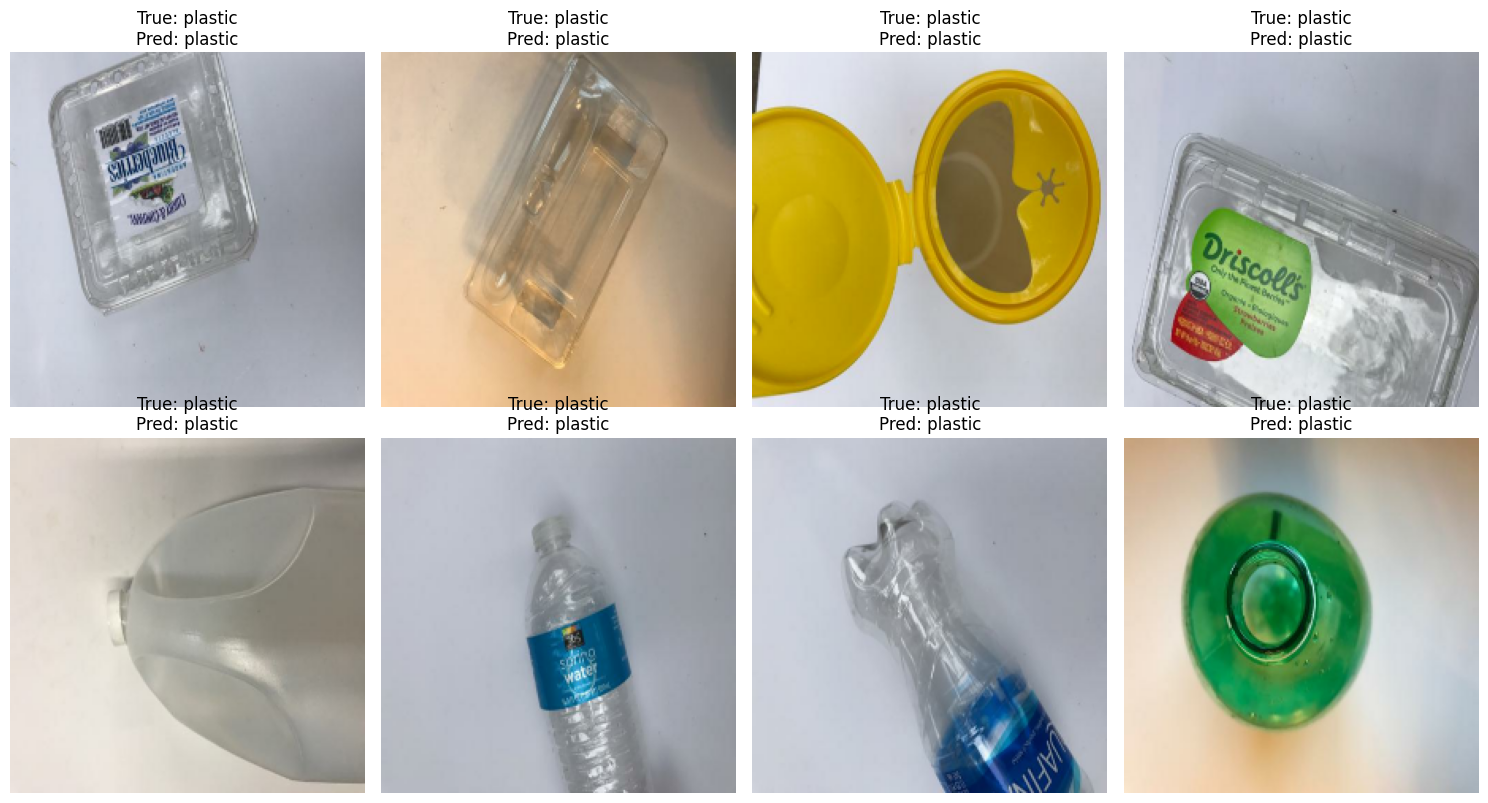

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 8))
for images, labels in test_ds.take(1): # Take one batch for visualization
    predictions = model.predict(images)
    pred_labels = np.argmax(predictions, axis=1) # Get predicted class labels

    for i in range(min(len(images), 8)): # Display up to 8 images
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [27]:
# Save as .h5 for portability
model.save("garbage_classifier_model_v2b0.h5")

# OR save in TensorFlow's native format
model.save("garbage_classifier_model_v2b0.keras")


# Model Deployment

In [36]:
import tensorflow as tf
import numpy as np
from PIL import Image
import gradio as gr
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Load your trained model
model = tf.keras.models.load_model("garbage_classifier_model_v2b0.h5")
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Prediction function
def classify_image(img):
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0]
    class_index = np.argmax(prediction)
    class_label = class_names[class_index]
    confidence = round(float(prediction[class_index]), 2)
    return f"Predicted: {class_label} (Confidence: {confidence})"

# Gradio Interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Classifier",
    description="Upload a garbage image and the model will predict the type."
)

# Launch Gradio app with public link (useful in Colab)
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0f1f6e64a850936f0f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
